# Electron Photon tagging

This is a first test to implement a QAE. 
The task is to identify Electrons and Photons from em-calorimeter images.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
import tensorflow as tf
import tensorflow_quantum as tfq
from hep_VQAE import data_preprocessing as dp
from hep_VQAE import CAE as cae
from tensorflow.keras import layers, losses
import h5py
from sklearn.model_selection import train_test_split
from matplotlib.colors import LogNorm

import warnings
warnings.filterwarnings('ignore')

2022-07-19 01:44:16.402836: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-19 01:44:16.402860: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/tom/.conda/envs/tfq/lib/python3.9/site-packages/cirq/ops/gateset.py:376: UserWarning: v0.14.1 is the last release `cirq.GlobalPhaseGate` is included by default. If you were relying on this behavior, you can include a `cirq.GlobalPhaseGate` in your `*gates`. If not, then you can ignore this warning. It will be removed in v0.16
  warnings.warn(
2022-07-19 01:44:17.660003: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-19 01:44:17.660022: W tensorflow/

In [2]:
f = h5py.File("../../data/electron.hdf5","r")
f2 = h5py.File("../../data/photon.hdf5","r")

In [3]:
electrons = f.get('X')[:,:,:,0]
photons = f2.get('X')[:,:,:,0]
electrons_y = f.get('y')[:]
photons_y = f2.get('y')[:]

In [4]:
x_train, x_val, y_train, y_val = train_test_split(np.vstack((electrons,photons)),
                                                    np.transpose(np.hstack((electrons_y, photons_y))),
                                                    test_size=0.2, shuffle=True)

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train,
                                                    test_size=0.4, shuffle=True)

In [5]:
x_train_electrons = x_train[y_train==1]
x_train = x_train[y_train==0]

x_val_electrons = x_val[y_val==1]
x_val = x_val[y_val==0]

x_test_electrons = x_test[y_test==1]
x_test = x_test[y_test==0]

In [6]:
x_train = x_train.reshape(x_train.shape + (1,))
x_train_electrons = x_train_electrons.reshape(x_train_electrons.shape + (1,))

x_val = x_val.reshape(x_val.shape + (1,))
x_val_electrons = x_val_electrons.reshape(x_val_electrons.shape + (1,))

x_test = x_test.reshape(x_test.shape + (1,))
x_test_electrons = x_test_electrons.reshape(x_test_electrons.shape + (1,))

In [7]:
max_norm = np.max(x_train)
x_train = x_train / max_norm
x_train_electrons = x_train_electrons / max_norm

x_val = x_val / max_norm
x_val_electrons = x_val_electrons / max_norm

x_test = x_test / max_norm
x_test_electrons = x_test_electrons / max_norm

In [8]:
latent_dim = 32
ae = cae.Convolutional_Autoencoder3(56)

In [9]:
ae.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(0.000005))

In [10]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3,min_delta=0.0001)
hist = ae.fit(x_train,x_train,
                epochs=12,
                shuffle=True,
                batch_size=64,
                validation_data=(x_val,x_val),
                callbacks=[es])

Epoch 1/12
1870/1870 [==============================] - 88s 46ms/step - loss: 0.6793 - val_loss: 0.6443
Epoch 2/12
1870/1870 [==============================] - 91s 49ms/step - loss: 0.4345 - val_loss: 0.1893
Epoch 3/12
1870/1870 [==============================] - 94s 50ms/step - loss: 0.1145 - val_loss: 0.0794
Epoch 4/12
1870/1870 [==============================] - 94s 50ms/step - loss: 0.0658 - val_loss: 0.0542
Epoch 5/12
1870/1870 [==============================] - 97s 52ms/step - loss: 0.0441 - val_loss: 0.0343
Epoch 6/12
1870/1870 [==============================] - 103s 55ms/step - loss: 0.0265 - val_loss: 0.0194
Epoch 7/12
1870/1870 [==============================] - 104s 56ms/step - loss: 0.0137 - val_loss: 0.0094
Epoch 8/12
1870/1870 [==============================] - 100s 53ms/step - loss: 0.0074 - val_loss: 0.0060
Epoch 9/12
1870/1870 [==============================] - 100s 53ms/step - loss: 0.0053 - val_loss: 0.0047
Epoch 10/12
1870/1870 [==============================] - 100

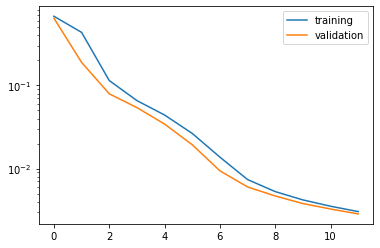

In [11]:
plt.plot(hist.history['loss'], label="training")
plt.plot(hist.history['val_loss'], label="validation")
plt.yscale('log')
plt.legend()

In [12]:
def mae(x):
    pred = ae.predict(x)
    return np.mean(np.abs(x - pred)**2,axis=(1,2,3))

def recon_acc(x):
    return 1 - mae(x)

In [13]:
photons = recon_acc(x_test)
electrons = recon_acc(x_test_electrons)

In [14]:
photon_energy = np.sum(x_test,axis=(1,2,3))
electron_energy = np.sum(x_test_electrons,axis=(1,2,3))

0.9999351
0.9999419


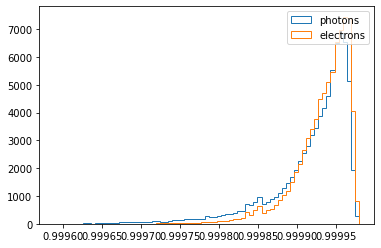

In [15]:
print(np.median(photons))
bins = np.histogram(np.hstack((photons, electrons)), bins=75)[1]
plt.hist(photons, histtype='step', label="photons",bins=bins)#,bins=[0.0004,0.0005,0.0006,0.0007,0.0008,0.0009,0.001,0.0011,0.0012,0.0013])
print(np.median(electrons))
plt.hist(electrons, histtype='step', label="electrons",bins=bins)#,bins=[0.0004,0.0005,0.0006,0.0007,0.0008,0.0009,0.001,0.0011,0.0012,0.0013])
plt.legend()

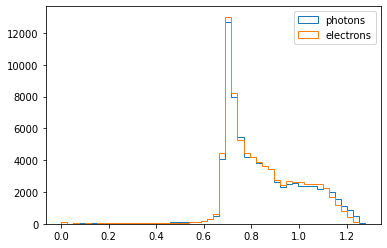

In [16]:
bins = np.histogram(np.hstack((photon_energy, electron_energy)), bins=50)[1]
plt.hist(photon_energy, histtype='step', label="photons",bins=bins)#,bins=[0.0004,0.0005,0.0006,0.0007,0.0008,0.0009,0.001,0.0011,0.0012,0.0013])
plt.hist(electron_energy, histtype='step', label="electrons",bins=bins)#,bins=[0.0004,0.0005,0.0006,0.0007,0.0008,0.0009,0.001,0.0011,0.0012,0.0013])
plt.legend()

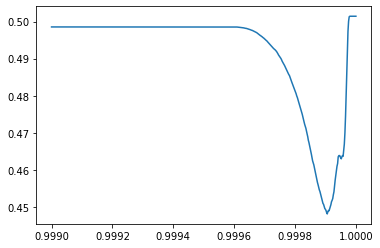

In [17]:
def acc_for_threshold(T):
    # sixes that are predicted photon
    num_six_right = np.sum(photons > T)
    # threes that are predicted three
    num_three_right = np.sum(electrons < T)
   
    acc = (num_six_right + num_three_right)/(len(photons) + len(electrons))
    return acc

Ts = np.linspace(0.999,1,500)
accs = []
for i in Ts:
    accs.append(acc_for_threshold(i))
plt.plot(Ts, accs) 

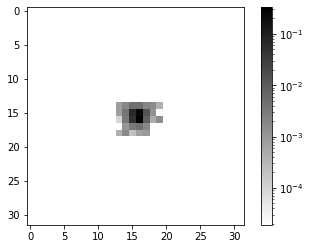

In [18]:
num = 16
testimg = ae.predict(x_test[num].reshape((1,32,32,1)))
plt.imshow(x_test[num].reshape((32,32)),cmap="binary",norm=LogNorm())
plt.colorbar()

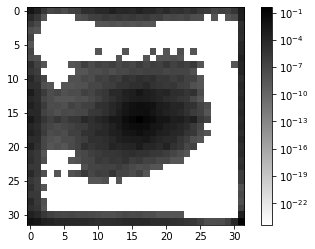

In [19]:
plt.imshow(testimg.reshape((32,32)),cmap="binary",norm=LogNorm())
plt.colorbar()

In [20]:
from hep_VQAE import utils as ut

In [21]:
ut.test_collapse(x_test[:7000], ae.predict(x_test[:7000]))

5.837391e-06

In [22]:
tf.image.ssim(x_test[:100].reshape(100,32,32,1).astype('float64'),ae(x_test[:100].reshape(100,32,32,1)).numpy().astype('float64'),max_val=1.0)

<tf.Tensor: shape=(100,), dtype=float32, numpy=
array([0.96889526, 0.9842333 , 0.98018205, 0.9632004 , 0.96498203,
       0.9833983 , 0.9465837 , 0.98910165, 0.9826056 , 0.96653265,
       0.9658493 , 0.96641874, 0.9667296 , 0.9757961 , 0.9765395 ,
       0.9863374 , 0.974855  , 0.9850989 , 0.9768409 , 0.9827306 ,
       0.9768515 , 0.99125934, 0.97843677, 0.9880542 , 0.9882051 ,
       0.98344004, 0.988082  , 0.9659368 , 0.9791679 , 0.99219304,
       0.9924968 , 0.9688932 , 0.96914077, 0.9906951 , 0.98329103,
       0.99127764, 0.98901826, 0.9673196 , 0.96370435, 0.9902483 ,
       0.977265  , 0.97967154, 0.98973733, 0.9717941 , 0.98972344,
       0.97674364, 0.9910204 , 0.94816345, 0.99050075, 0.9880041 ,
       0.9642424 , 0.9878472 , 0.97020286, 0.98885417, 0.99102217,
       0.9645279 , 0.9882992 , 0.98671293, 0.9844013 , 0.97272384,
       0.9775494 , 0.9864876 , 0.98878056, 0.9916818 , 0.9813509 ,
       0.97080773, 0.96629214, 0.9836022 , 0.96728474, 0.9250297 ,
       0.91128

In [23]:
MAE = tf.reduce_mean(tf.abs(x_test[:100].reshape(100,32,32,1) - ae(x_test[:100].reshape(100,32,32,1)).numpy()))

In [24]:
MAE

<tf.Tensor: shape=(), dtype=float32, numpy=0.000717372>

In [25]:
ut.intensity_hist(x_test[num], ae(x_test[num].reshape((1,32,32,1))).numpy())[-20:]

array([ 7.1987443 ,  3.0651145 ,  2.2739842 ,  3.3706973 ,  1.8429179 ,
       10.341831  ,  1.4632572 ,  4.2521434 ,  6.8160863 ,  6.253312  ,
        0.88752806,  1.471527  ,  3.3165789 ,  5.4831614 ,  7.288717  ,
        1.1509699 ,  1.3959793 ,  0.11555427,  0.05588317,  1.1279751 ],
      dtype=float32)

In [26]:
MAE = tf.reduce_mean(tf.abs(x_test[:100].reshape(100,32,32,1) - ae(x_test[:100].reshape(100,32,32,1)).numpy())/tf.reduce_sum(x_test[:100],axis=(1,2)).numpy().reshape((100,1,1,1)))

In [27]:
MAE

<tf.Tensor: shape=(), dtype=float32, numpy=0.00085562334>